In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model-ckpt/my_peract.pth
/kaggle/input/vae-encoder/encoder.py
/kaggle/input/vae-encoder/attention.py
/kaggle/input/vae-encoder/decoder.py


# **PerAct**
### Annotated Tutorial

**Important: Before starting, change the runtime to GPU.**

This notebook is an annotated tutorial on training [Perceiver-Actor (PerAct)](https://peract.github.io/) from scratch. We will look at training a single-task agent on the `open_drawer` task.  The tutorial will start from loading calibrated RGB-D images, and end with visualizing *action detections* in voxelized observations. Overall, this guide is
meant to complement the [paper](https://peract.github.io/) by providing concrete implementation details.  

### Full Code
See [this Github repository](https://github.com/peract/peract) for the full code, pre-trained checkpoints, and pre-generated datasets. You should be able to use the pre-generated datasets with this notebook.

### Credit
This notebook heavily builds on data-loading and pre-preprocessing code from [`ARM`](https://github.com/stepjam/ARM), [`YARR`](https://github.com/stepjam/YARR), [`PyRep`](https://github.com/stepjam/PyRep), [`RLBench`](https://github.com/stepjam/RLBench) by [James et al.](https://stepjam.github.io/) The [PerceiverIO](https://arxiv.org/abs/2107.14795) code is adapted from [`perceiver-pytorch`](https://github.com/lucidrains/perceiver-pytorch) by [Phil Wang (lucidrains)](https://github.com/lucidrains). The optimizer is based on [this LAMB implementation](https://github.com/cybertronai/pytorch-lamb). See the corresponding licenses below.

<img src="https://peract.github.io/media/figures/sim_task.jpg" alt="drawing" style="width:100px;"/>

### Licenses
- [PerAct License (Apache 2.0)](https://github.com/peract/peract/blob/main/LICENSE) - Perceiver-Actor Transformer
- [ARM License](https://github.com/peract/peract/blob/main/ARM_LICENSE) - Voxelization and Data Preprocessing
- [YARR Licence (Apache 2.0)](https://github.com/stepjam/YARR/blob/main/LICENSE)
- [RLBench Licence](https://github.com/stepjam/RLBench/blob/master/LICENSE)
- [PyRep License (MIT)](https://github.com/stepjam/PyRep/blob/master/LICENSE)
- [Perceiver PyTorch License (MIT)](https://github.com/lucidrains/perceiver-pytorch/blob/main/LICENSE)
- [LAMB License (MIT)](https://github.com/cybertronai/pytorch-lamb/blob/master/LICENSE)
- [CLIP License (MIT)](https://github.com/openai/CLIP/blob/main/LICENSE)


### Install Dependencies

In [2]:
!pip install scipy ftfy regex tqdm torch git+https://github.com/openai/CLIP.git einops pyrender==0.1.45 trimesh==3.9.34 pycollada==0.6 natsort

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-dfl3bsc7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-dfl3bsc7
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.8/638.8 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.3/884.3 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

### Clone Repo and Setup

Clone [https://github.com/peract/peract_colab.git](github.com/peract/peract_colab.git).   

This repo contains barebones code from [`ARM`](https://github.com/stepjam/ARM), [`YARR`](https://github.com/stepjam/YARR), [`PyRep`](https://github.com/stepjam/PyRep), [`RLBench`](https://github.com/stepjam/RLBench) to get started with  PerAct without the actual [V-REP](https://www.coppeliarobotics.com/) simulator.

The repo also contains a pre-generated RLBench dataset of 10 expert demonstrations for the `open_drawer` task. This task has three variations: "open the top drawer", "open the middle drawer", and "open the bottom drawer"



In [3]:
!git clone https://github.com/peract/peract_colab.git

Cloning into 'peract_colab'...
remote: Enumerating objects: 16388, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 16388 (delta 104), reused 193 (delta 103), pack-reused 16193
Receiving objects: 100% (16388/16388), 178.97 MiB | 46.36 MiB/s, done.
Resolving deltas: 100% (113/113), done.
Updating files: 100% (16260/16260), done.


If you fork-off this repo, you might want to pull the latest changes.

In [4]:
!cd peract_colab && git pull origin master

From https://github.com/peract/peract_colab
 * branch              master     -> FETCH_HEAD
Already up to date.


Set `PYOPENGL_PLATFORM=egl` for pyrender visualizations

In [5]:
import numpy as np
np.bool = np.bool_ # bad trick to fix numpy version issue :(
import os
import sys
import shutil
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["DISPLAY"] = ":0"
os.environ["PYOPENGL_PLATFORM"] = "egl"

Define some constants and setting variables.

The `BATCH_SIZE` is 1 to fit the model on a single GPU. But you can play around with the voxel sizes and Transformer layers to increase this.  

In the paper, we use `NUM_LATENTS=2048` by default, but smaller latents like `512` are also fine (see Appendix G).

In [6]:
# constants
TASK = 'open_drawer'
DATA_FOLDER ='peract_colab/data'
EPISODES_FOLDER = 'colab_dataset/open_drawer/all_variations/episodes'
EPISODE_FOLDER = 'episode%d'
CAMERAS = ['front', 'left_shoulder', 'right_shoulder', 'wrist']
LOW_DIM_SIZE = 4   # {left_finger_joint, right_finger_joint, gripper_open, timestep}
IMAGE_SIZE =  128  # 128x128 - if you want to use higher voxel resolutions like 200^3, you might want to regenerate the dataset with larger images
VARIATION_DESCRIPTIONS_PKL = 'variation_descriptions.pkl' # the pkl file that contains language goals for each demonstration
EPISODE_LENGTH = 10 # max steps for agents
DEMO_AUGMENTATION_EVERY_N = 10 # sample n-th frame in demo
ROTATION_RESOLUTION = 5 # degree increments per axis

# settings
VOXEL_SIZES = [100] # 100x100x100 voxels
NUM_LATENTS = 512 # PerceiverIO latents
SCENE_BOUNDS = [-0.3, -0.5, 0.6, 0.7, 0.5, 1.6] # [x_min, y_min, z_min, x_max, y_max, z_max] - the metric volume to be voxelized
BATCH_SIZE = 1
NUM_DEMOS = 8 # total number of training demonstrations to use while training PerAct
NUM_TEST = 2 # episodes to evaluate on

Add `peract_colab` to the system path and make a directory for storing the replay buffer.  For now, we will store the replay buffer on disk to avoid memory issues with putting everthing on RAM.

In [7]:
sys.path.append('peract_colab')
data_path = os.path.join(DATA_FOLDER, EPISODES_FOLDER)

train_replay_storage_dir = 'replay_train'
if not os.path.exists(train_replay_storage_dir):
  os.mkdir(train_replay_storage_dir)

test_replay_storage_dir = 'replay_test'
if not os.path.exists(test_replay_storage_dir):
  os.mkdir(test_replay_storage_dir)

## Data Loading & Preprocessing

An expert demonstration recorded at ~20Hz contains 100s of individual timesteps in a sequence. Each timestep contains observations recorded from 4 calibrated cameras (front, left_shoulder, right_shoulder, and wrist) and other proprioception sensors. "Calibrated" means we know the extrinsics and intrinsics.

Let's take a look at what these observations look like. Play around with different `episode_idx_to_visualize` and timesteps `ts`.

[0.         0.00731409 0.00666034 1.4444444 ]
Demo 1 | 108 total steps



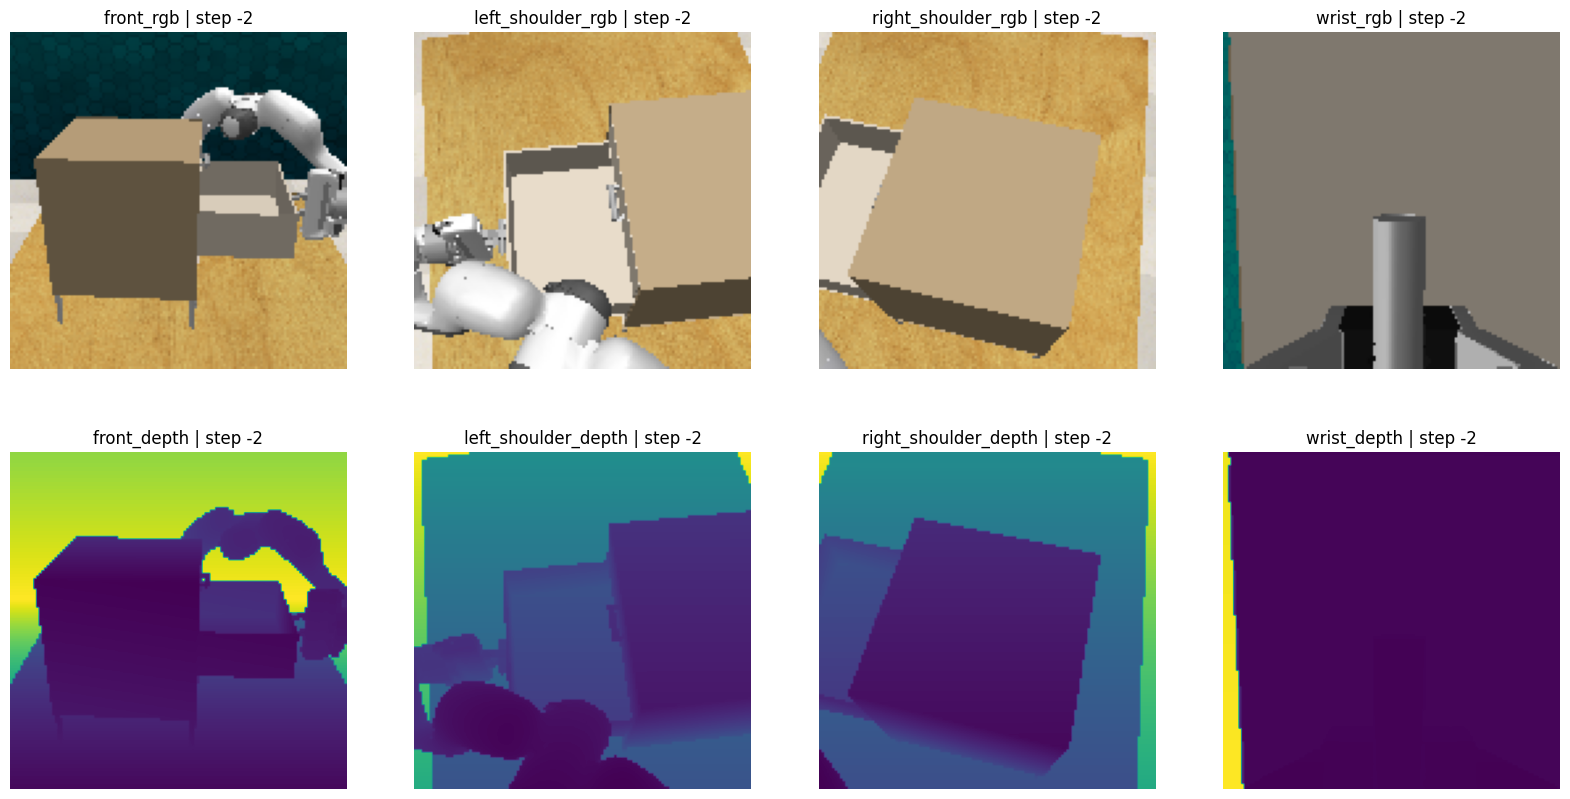

In [8]:
from rlbench.utils import get_stored_demo
from rlbench.backend.utils import extract_obs

# what to visualize
episode_idx_to_visualize = 1 # out of 10 demos
ts = -2 # timestep out of total timesteps

# get demo
demo = get_stored_demo(data_path=data_path,
                      index=episode_idx_to_visualize)

# extract obs at timestep
obs_dict = extract_obs(demo._observations[ts], CAMERAS, t=ts)
print(obs_dict['low_dim_state'])
# total timesteps in demo
print(f"Demo {episode_idx_to_visualize} | {len(demo._observations)} total steps\n")

# plot rgb and depth at timestep
fig = plt.figure(figsize=(20, 10))
rows, cols = 2, len(CAMERAS)

plot_idx = 1
for camera in CAMERAS:
  # rgb
  rgb_name = "%s_%s" % (camera, 'rgb')
  rgb = np.transpose(obs_dict[rgb_name], (1, 2, 0))
  fig.add_subplot(rows, cols, plot_idx)
  plt.imshow(rgb)
  plt.axis('off')
  plt.title("%s_rgb | step %s" % (camera, ts))

  # depth
  depth_name = "%s_%s" % (camera, 'depth')
  depth = np.transpose(obs_dict[depth_name], (1, 2, 0)).reshape(IMAGE_SIZE, IMAGE_SIZE)
  fig.add_subplot(rows, cols, plot_idx+len(CAMERAS))
  plt.imshow(depth)
  plt.axis('off')
  plt.title("%s_depth | step %s" % (camera, ts))

  plot_idx += 1

plt.show()

### Create Replay Buffer

As described in **Section 3.4** of the paper, PerAct is trained with discrete-time input-action tuples from a dataset of demonstrations. These tuples are stored in a Replay Buffer following the [`ARM`](https://github.com/stepjam/ARM) codebase. You can use your own storage format, but here we follow `ARM` to benchmark against baselines and other methods by James et al.

This replay buffer stores **<observation, language goal, keyframe action>** tuples sampled from demonstrations.

In [9]:
# Adapted from: https://github.com/stepjam/ARM/blob/main/arm/c2farm/launch_utils.py

from yarr.utils.observation_type import ObservationElement
from yarr.replay_buffer import ReplayElement, ReplayBuffer
from yarr.replay_buffer.uniform_replay_buffer import UniformReplayBuffer


def create_replay(batch_size: int,
                  timesteps: int,
                  save_dir: str,
                  cameras: list,
                  voxel_sizes,
                  replay_size=3e5):

    trans_indicies_size = 3 * len(voxel_sizes)
    rot_and_grip_indicies_size = (3 + 1)
    gripper_pose_size = 7
    ignore_collisions_size = 1
    max_token_seq_len = 77
    lang_feat_dim = 1024
    lang_emb_dim = 512

    # low_dim_state
    observation_elements = []
    observation_elements.append(
        ObservationElement('low_dim_state', (LOW_DIM_SIZE,), np.float32))

    # rgb, depth, point cloud, intrinsics, extrinsics
    for cname in cameras:
        observation_elements.append(
            ObservationElement('%s_rgb' % cname, (3, IMAGE_SIZE, IMAGE_SIZE,), np.float32))
        observation_elements.append(
            ObservationElement('%s_depth' % cname, (1, IMAGE_SIZE, IMAGE_SIZE,), np.float32))
        observation_elements.append(
            ObservationElement('%s_point_cloud' % cname, (3, IMAGE_SIZE, IMAGE_SIZE,), np.float32)) # see pyrep/objects/vision_sensor.py on how pointclouds are extracted from depth frames
        observation_elements.append(
            ObservationElement('%s_camera_extrinsics' % cname, (4, 4,), np.float32))
        observation_elements.append(
            ObservationElement('%s_camera_intrinsics' % cname, (3, 3,), np.float32))

    # discretized translation, discretized rotation, discrete ignore collision, 6-DoF gripper pose, and pre-trained language embeddings
    observation_elements.extend([
        ReplayElement('trans_action_indicies', (trans_indicies_size,),
                      np.int32),
        ReplayElement('rot_grip_action_indicies', (rot_and_grip_indicies_size,),
                      np.int32),
        ReplayElement('ignore_collisions', (ignore_collisions_size,),
                      np.int32),
        ReplayElement('gripper_pose', (gripper_pose_size,),
                      np.float32),
        ReplayElement('lang_goal_embs', (max_token_seq_len, lang_emb_dim,), # extracted from CLIP's language encoder
                      np.float32),
        ReplayElement('lang_goal', (1,), object), # language goal string for debugging and visualization
    ])

    extra_replay_elements = [
        ReplayElement('demo', (), np.bool),
    ]

    replay_buffer = UniformReplayBuffer( # all tuples in the buffer have equal sample weighting
        save_dir=save_dir,
        batch_size=batch_size,
        timesteps=timesteps,
        replay_capacity=int(replay_size),
        action_shape=(8,), # 3 translation + 4 rotation quaternion + 1 gripper open
        action_dtype=np.float32,
        reward_shape=(),
        reward_dtype=np.float32,
        update_horizon=1,
        observation_elements=observation_elements,
        extra_replay_elements=extra_replay_elements
    )
    return replay_buffer

train_replay_buffer = create_replay(batch_size=BATCH_SIZE,
                                    timesteps=1,
                                    save_dir=train_replay_storage_dir,
                                    cameras=CAMERAS,
                                    voxel_sizes=VOXEL_SIZES)

test_replay_buffer = create_replay(batch_size=BATCH_SIZE,
                                   timesteps=1,
                                   save_dir=test_replay_storage_dir,
                                   cameras=CAMERAS,
                                   voxel_sizes=VOXEL_SIZES)



### Fill Replay with Demos

#### Keyframe Extraction

Instead of directly trying to predict every action in the demonstration, which could be very noisy and inefficient, we extract keyframe actions that capture **bottleneck** poses \[[James et al.](https://arxiv.org/abs/2105.14829)\]. This extraction is done with a simple heuristic: an action is a keyframe action if (1) the joint-velocities are near zero and (2) the gripper open state has not changed. Then every timestep in the demonstration can be cast as a predict "the next (best) keyframe" classification task, like the orange points in this figure:  

<div>
<img src="https://peract.github.io/media/figures/keypoints.jpg" alt="drawing"  width="300"/>
</div>

In [10]:
# From https://github.com/stepjam/ARM/blob/main/arm/demo_loading_utils.py

from rlbench.demo import Demo
from typing import List

def _is_stopped(demo, i, obs, stopped_buffer, delta=0.1):
    next_is_not_final = i == (len(demo) - 2)
    gripper_state_no_change = (
            i < (len(demo) - 2) and
            (obs.gripper_open == demo[i + 1].gripper_open and
             obs.gripper_open == demo[i - 1].gripper_open and
             demo[i - 2].gripper_open == demo[i - 1].gripper_open))
    small_delta = np.allclose(obs.joint_velocities, 0, atol=delta)
    stopped = (stopped_buffer <= 0 and small_delta and
               (not next_is_not_final) and gripper_state_no_change)
    return stopped

def _keypoint_discovery(demo: Demo,
                        stopping_delta=0.1) -> List[int]:
    episode_keypoints = []
    prev_gripper_open = demo[0].gripper_open
    stopped_buffer = 0
    for i, obs in enumerate(demo):
        stopped = _is_stopped(demo, i, obs, stopped_buffer, stopping_delta)
        stopped_buffer = 4 if stopped else stopped_buffer - 1
        # if change in gripper, or end of episode.
        last = i == (len(demo) - 1)
        if i != 0 and (obs.gripper_open != prev_gripper_open or
                        last or stopped):
            episode_keypoints.append(i)
        prev_gripper_open = obs.gripper_open
    if len(episode_keypoints) > 1 and (episode_keypoints[-1] - 1) == \
            episode_keypoints[-2]:
        episode_keypoints.pop(-2)
    print('Found %d keypoints.' % len(episode_keypoints), episode_keypoints)
    return episode_keypoints

Let's take a look at what these keyframe actions look like.  



Demo 1 | 108 total steps
Found 3 keypoints. [64, 77, 107]


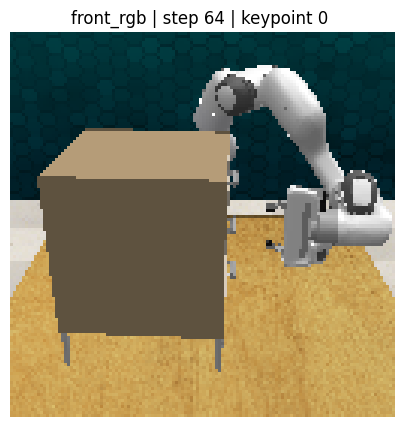

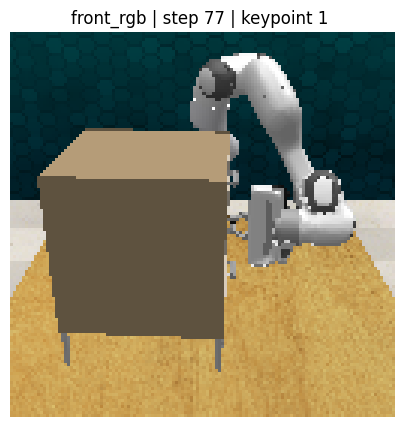

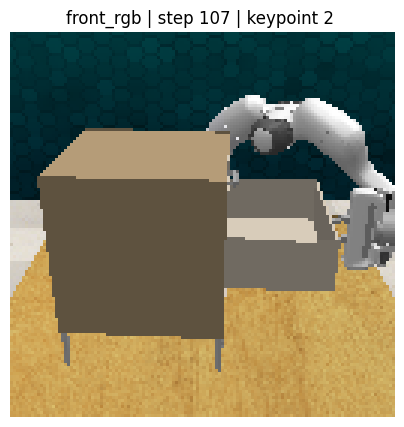

In [11]:
# use Demo 1 like last time
episode_idx_to_visualize = 1
demo = get_stored_demo(data_path=data_path,
                      index=episode_idx_to_visualize)

# total timesteps
print("Demo %s | %s total steps" % (episode_idx_to_visualize, len(demo._observations)))

# use the heuristic to extract keyframes (aka keypoints)
episode_keypoints = _keypoint_discovery(demo)

# visualize rgb observations from these keyframes
for kp_idx, kp in enumerate(episode_keypoints):
    obs_dict = extract_obs(demo._observations[kp], CAMERAS, t=kp)

    fig = plt.figure(figsize=(5, 5))
    rgb_name = "front_rgb"
    rgb = np.transpose(obs_dict[rgb_name], (1, 2, 0))
    plt.imshow(rgb)
    plt.axis('off')
    plt.title("front_rgb | step %s | keypoint %s " % (kp, kp_idx))
    plt.show()

Notice that the motion-planner used to generate demonstrations might take various paths to execute the "opening" motion, but all paths strictly pass through these **bottleneck** poses, since that's how the expert demonstrations were collected in RLBench. This essentially circuments the issue of training directly on randomized motion paths from sampling-based motion planners, which can be quite noisy to learn from for end-to-end methods.

#### Fill Replay

Some helper functions for filling the replay.

In [12]:
def _norm_rgb(x):
    return (x.float() / 255.0) * 2.0 - 1.0

def process_replay_output(out):
  out = torch.stack(out).transpose(0,1).float()
  return out

def _denorm_rgb(x):
    return ((x + 1.0) * 255 / 2).int() # y = (x.float() / 255.0) * 2.0 - 1.0

In [13]:
import clip
import torch
import arm.utils as utils

from rlbench.backend.observation import Observation
from yarr.replay_buffer.replay_buffer import ReplayBuffer

# discretize translation, rotation, gripper open, and ignore collision actions
def _get_action(
        obs_tp1: Observation,
        obs_tm1: Observation,
        rlbench_scene_bounds: List[float], # metric 3D bounds of the scene
        voxel_sizes: List[int],
        rotation_resolution: int,
        crop_augmentation: bool):
    quat = utils.normalize_quaternion(obs_tp1.gripper_pose[3:])
    if quat[-1] < 0:
        quat = -quat
    disc_rot = utils.quaternion_to_discrete_euler(quat, rotation_resolution)
    attention_coordinate = obs_tp1.gripper_pose[:3]
    trans_indicies, attention_coordinates = [], []
    bounds = np.array(rlbench_scene_bounds)
    ignore_collisions = int(obs_tm1.ignore_collisions)
    for depth, vox_size in enumerate(voxel_sizes): # only single voxelization-level is used in PerAct
        index = utils.point_to_voxel_index(
            obs_tp1.gripper_pose[:3], vox_size, bounds)
        trans_indicies.extend(index.tolist())
        res = (bounds[3:] - bounds[:3]) / vox_size
        attention_coordinate = bounds[:3] + res * index
        attention_coordinates.append(attention_coordinate)

    rot_and_grip_indicies = disc_rot.tolist()
    grip = float(obs_tp1.gripper_open)
    rot_and_grip_indicies.extend([int(obs_tp1.gripper_open)])
    return trans_indicies, rot_and_grip_indicies, ignore_collisions, np.concatenate(
        [obs_tp1.gripper_pose, np.array([grip])]), attention_coordinates

# extract CLIP language features for goal string
def _clip_encode_text(clip_model, text):
    x = clip_model.token_embedding(text).type(clip_model.dtype)  # [batch_size, n_ctx, d_model]

    x = x + clip_model.positional_embedding.type(clip_model.dtype)
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = clip_model.transformer(x)
    x = x.permute(1, 0, 2)  # LND -> NLD
    x = clip_model.ln_final(x).type(clip_model.dtype)

    emb = x.clone()
    x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ clip_model.text_projection

    return x, emb

# add individual data points to replay
def _add_keypoints_to_replay(
        replay: ReplayBuffer,
        inital_obs: Observation,
        demo: Demo,
        episode_keypoints: List[int],
        cameras: List[str],
        rlbench_scene_bounds: List[float],
        voxel_sizes: List[int],
        rotation_resolution: int,
        crop_augmentation: bool,
        description: str = '',
        clip_model = None,
        device = 'cpu'):
    prev_action = None
    obs = inital_obs
    for k, keypoint in enumerate(episode_keypoints):
        obs_tp1 = demo[keypoint]
        obs_tm1 = demo[max(0, keypoint - 1)]
        trans_indicies, rot_grip_indicies, ignore_collisions, action, attention_coordinates = _get_action(
            obs_tp1, obs_tm1, rlbench_scene_bounds, voxel_sizes,
            rotation_resolution, crop_augmentation)
        terminal = (k == len(episode_keypoints) - 1)
        reward = float(terminal) * 1.0 if terminal else 0

        obs_dict = extract_obs(obs, CAMERAS, t=k, prev_action=prev_action)
        tokens = clip.tokenize([description]).numpy()
        token_tensor = torch.from_numpy(tokens).to(device)
        lang_feats, lang_embs = _clip_encode_text(clip_model, token_tensor)
        obs_dict['lang_goal_embs'] = lang_embs[0].float().detach().cpu().numpy()

        prev_action = np.copy(action)

        others = {'demo': True}
        final_obs = {
            'trans_action_indicies': trans_indicies,
            'rot_grip_action_indicies': rot_grip_indicies,
            'gripper_pose': obs_tp1.gripper_pose,
            'lang_goal': np.array([description], dtype=object),
        }

        others.update(final_obs)
        others.update(obs_dict)

        timeout = False
        replay.add(action, reward, terminal, timeout, **others)
        obs = obs_tp1

    # final step
    obs_dict_tp1 = extract_obs(obs_tp1, CAMERAS, t=k + 1, prev_action=prev_action)
    obs_dict_tp1['lang_goal_embs'] = lang_embs[0].float().detach().cpu().numpy()

    obs_dict_tp1.pop('wrist_world_to_cam', None)
    obs_dict_tp1.update(final_obs)
    replay.add_final(**obs_dict_tp1)

def _add_seq_of_keypoints_to_replay(
        replay: ReplayBuffer,
        demo: Demo,
        cameras: List[str],
        rlbench_scene_bounds: List[float],
        voxel_sizes: List[int],
        rotation_resolution: int,
        crop_augmentation: bool,
        description: str = '',
        clip_model = None,
        device = 'cpu'):

    curr_action = np.zeros(8)
    episode_indices = list(range(len(demo)-1, -1, -5))
    episode_indices.reverse()
    
    s = len(episode_indices) % 5
    episode_indices = episode_indices[s:]
    obs = demo[0]
    curr_index = 0
    curr_reward = 0

    actions_list = []
    rgb_list = []
    ignore_list = []
    lang_goals_list = []
    rewards_list = []
    terminal_list = []
    low_dim_list = []

    targets_actions = []
    targets_rgb = []
    targets_rewards = []
    
    indices = []

#     is_even = i % 5 == 0
#     count = 4
#     print("start",i)
#     print("zzzzzzzz",len(episode_idices) - 1)
    print(episode_indices)
    for next_index in episode_indices:
#         print(next_index)
#         skip = next_index % 2 != 0 if is_even else next_index % 2 == 0
#         if count != 0:
#           count -= 1
#           continue
        # print(index)
#         print(indices)
#         count = 4
        indices.append((curr_index, next_index))
        obs_tp1 = demo[next_index]
        obs_tm1 = demo[curr_index]
        trans_indicies, rot_grip_indicies, ignore_collisions, next_action, attention_coordinates = _get_action(
            obs_tp1, obs_tm1, rlbench_scene_bounds, voxel_sizes,
            rotation_resolution, crop_augmentation)

        terminal = (next_index == (len(demo) - 1))

        next_reward = float(terminal) * 1.0 if terminal else 0.0
        if next_reward == 1.0:
          print(curr_index, next_index, curr_reward, next_reward)

        obs_dict = extract_obs(obs, cameras, t=curr_index, prev_action=curr_action)

        tokens = clip.tokenize([description]).numpy()
        token_tensor = torch.from_numpy(tokens).to(device)
        lang_feats, lang_embs = _clip_encode_text(clip_model, token_tensor)
        obs_dict['lang_goal_embs'] = lang_embs[0].float().detach().cpu().numpy()

        # print(reward)
        actions_list.append(curr_action)
        # targets_list.append(action)
        # states_list.append(np.concatenate((obs.gripper_pose,[obs.gripper_open])))
        img = obs_dict['front_rgb']
        rgb_list.append(img)

        ignore_list.append(ignore_collisions)

        lang_goals_list.append(lang_embs[0].float().detach().cpu().numpy())

        rewards_list.append(curr_reward)
        # terminal_list.append(terminal)
        low_dim_list.append(obs_dict['low_dim_state'])

        target_dict = extract_obs(obs_tp1, cameras, t=next_index, prev_action=next_action)

        targets_actions.append(next_action)
        t_img = target_dict['front_rgb']
        targets_rgb.append(t_img)
        targets_rewards.append(next_reward)

        curr_action = np.copy(next_action)
        obs = obs_tp1
        curr_index = next_index
        curr_reward = next_reward

#         if (next_index - i) > 0 and (next_index - i) % 10 == 0:
        if len(indices) == 5:
          # print(len(actions_list))
          print(indices)
          if terminal:
            print("terminal at", next_index)
#           print(rewards_list, targets_rewards)
          x = (actions_list[:], rgb_list[:], lang_goals_list[:], rewards_list[:], ignore_list[:], low_dim_list[:])
          y = (targets_actions[:], targets_rgb[:], targets_rewards[:])
          replay.push((x,y))

          # data = {}
          indices = []
          actions_list = []
          rgb_list = []
          ignore_list = []
          lang_goals_list = []
          rewards_list = []
          low_dim_list = []

          targets_actions = []
          targets_rgb = []
          targets_rewards = []

Finally fill the replay buffer.

In [14]:
import torch
import random
from collections import deque
from torch.utils.data import Dataset

class MyReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def __len__(self):
        return len(self.buffer)


class ReplayBufferDataset(Dataset):
    def __init__(self, replay_buffer):
        self.replay_buffer = replay_buffer

    def __len__(self):
        return len(self.replay_buffer)

    def __getitem__(self, idx):
        rb = self.replay_buffer.buffer[idx]
        return rb

In [15]:
def fill_replay(replay: ReplayBuffer,
                start_idx: int,
                num_demos: int,
                demo_augmentation: bool,
                demo_augmentation_every_n: int,
                cameras: List[str],
                rlbench_scene_bounds: List[float],  # AKA: DEPTH0_BOUNDS
                voxel_sizes: List[int],
                rotation_resolution: int,
                crop_augmentation: bool,
                clip_model = None,
                device = 'cpu'):
    print('Filling replay ...')
    for d_idx in range(start_idx, start_idx+num_demos):
        print("Filling demo %d" % d_idx)
        demo = get_stored_demo(data_path=data_path,
                               index=d_idx)

        # get language goal from disk
        varation_descs_pkl_file = os.path.join(data_path, EPISODE_FOLDER % d_idx, VARIATION_DESCRIPTIONS_PKL)
        with open(varation_descs_pkl_file, 'rb') as f:
          descs = pickle.load(f)

        # extract keypoints
        episode_keypoints = _keypoint_discovery(demo)

        for i in range(len(demo) - 1):
            if not demo_augmentation and i > 0:
                break
            if i % demo_augmentation_every_n != 0: # choose only every n-th frame
                continue

            obs = demo[i]
            desc = descs[0]
            # if our starting point is past one of the keypoints, then remove it
            while len(episode_keypoints) > 0 and i >= episode_keypoints[0]:
                episode_keypoints = episode_keypoints[1:]
            if len(episode_keypoints) == 0:
                break
            _add_keypoints_to_replay(
                replay, obs, demo, episode_keypoints, cameras,
                rlbench_scene_bounds, voxel_sizes,
                rotation_resolution, crop_augmentation, description=desc,
                clip_model=clip_model, device=device)
    print('Replay filled with demos.')

Load a [pre-trained CLIP model](https://arxiv.org/abs/2103.00020) to extract language features. You can probably swap this with other language models, but CLIP's language features were trained to be aligned with image features, which might give it a multi-modal edge over text-only models 🤷

In [16]:
def my_fill_replay(replay: ReplayBuffer,
                start_idx: int,
                num_demos: int,
                demo_augmentation: bool,
                demo_augmentation_every_n: int,
                cameras: List[str],
                rlbench_scene_bounds: List[float],  # AKA: DEPTH0_BOUNDS
                voxel_sizes: List[int],
                rotation_resolution: int,
                crop_augmentation: bool,
                clip_model = None,
                device = 'cpu'):
    print('Filling replay ...')
    for d_idx in range(start_idx, start_idx+num_demos):
        print("Filling demo %d" % d_idx)
        demo = get_stored_demo(data_path=data_path,
                               index=d_idx)

        # get language goal from disk
        varation_descs_pkl_file = os.path.join(data_path, EPISODE_FOLDER % d_idx, VARIATION_DESCRIPTIONS_PKL)
        with open(varation_descs_pkl_file, 'rb') as f:
          descs = pickle.load(f)

        episode_keypoints = _keypoint_discovery(demo)
        i = (len(demo) - 1) % 10 + 1

        # while i < len(demo) - 1:

        _add_seq_of_keypoints_to_replay(
              replay=replay,
              demo=demo,
              cameras=cameras,
              rlbench_scene_bounds=rlbench_scene_bounds,
              voxel_sizes=voxel_sizes,
              rotation_resolution=rotation_resolution,
              crop_augmentation=crop_augmentation,
              description=descs[0],
              clip_model = clip_model,
              device = device)
          # i += 10
        # print("last target index", i )

    print('Replay filled with demos.')

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("RN50", device=device) # CLIP-ResNet50

100%|███████████████████████████████████████| 244M/244M [00:03<00:00, 80.4MiB/s]


In [18]:
# from yarr.replay_buffer.wrappers.pytorch_replay_buffer import PyTorchReplayBuffer

# print("-- Train Buffer --")
# fill_replay(replay=train_replay_buffer,
#             start_idx=0,
#             num_demos=NUM_DEMOS,
#             demo_augmentation=True,
#             demo_augmentation_every_n=DEMO_AUGMENTATION_EVERY_N,
#             cameras=CAMERAS,
#             rlbench_scene_bounds=SCENE_BOUNDS,
#             voxel_sizes=VOXEL_SIZES,
#             rotation_resolution=ROTATION_RESOLUTION,
#             crop_augmentation=False,
#             clip_model=clip_model,
#             device=device)

# print("-- Test Buffer --")
# fill_replay(replay=test_replay_buffer,
#             start_idx=NUM_DEMOS,
#             num_demos=NUM_TEST,
#             demo_augmentation=True,
#             demo_augmentation_every_n=DEMO_AUGMENTATION_EVERY_N,
#             cameras=CAMERAS,
#             rlbench_scene_bounds=SCENE_BOUNDS,
#             voxel_sizes=VOXEL_SIZES,
#             rotation_resolution=ROTATION_RESOLUTION,
#             crop_augmentation=False,
#             clip_model=clip_model,
#             device=device)

# # delete the CLIP model since we have already extracted language features
# del clip_model

# # wrap buffer with PyTorch dataset and make iterator
# train_wrapped_replay = PyTorchReplayBuffer(train_replay_buffer)
# train_dataset = train_wrapped_replay.dataset()
# train_data_iter = iter(train_dataset)

# test_wrapped_replay = PyTorchReplayBuffer(test_replay_buffer)
# test_dataset = test_wrapped_replay.dataset()
# test_data_iter = iter(test_dataset)

In [19]:
my_train_replay = MyReplayBuffer(30000)

my_test_replay = MyReplayBuffer(30000)

In [20]:
from yarr.replay_buffer.wrappers.pytorch_replay_buffer import PyTorchReplayBuffer

print("-- Train Buffer --")
my_fill_replay(replay=my_train_replay,
            start_idx=0,
            num_demos=NUM_DEMOS,
            demo_augmentation=True,
            demo_augmentation_every_n=DEMO_AUGMENTATION_EVERY_N,
            cameras=CAMERAS,
            rlbench_scene_bounds=SCENE_BOUNDS,
            voxel_sizes=VOXEL_SIZES,
            rotation_resolution=ROTATION_RESOLUTION,
            crop_augmentation=False,
            clip_model=clip_model,
            device=device)

print("-- Test Buffer --")
my_fill_replay(replay=my_test_replay,
            start_idx=NUM_DEMOS,
            num_demos=NUM_TEST,
            demo_augmentation=True,
            demo_augmentation_every_n=DEMO_AUGMENTATION_EVERY_N,
            cameras=CAMERAS,
            rlbench_scene_bounds=SCENE_BOUNDS,
            voxel_sizes=VOXEL_SIZES,
            rotation_resolution=ROTATION_RESOLUTION,
            crop_augmentation=False,
            clip_model=clip_model,
            device=device)

# delete the CLIP model since we have already extracted language features
del clip_model
from torch.utils.data import DataLoader

my_train_dataset = ReplayBufferDataset(my_train_replay)
print(len(my_train_dataset))
batch_size = 1  # Specify your desired batch size
my_train_dataloader = DataLoader(my_train_dataset, batch_size=batch_size, shuffle=True)

my_test_dataset = ReplayBufferDataset(my_test_replay)
print(len(my_test_dataset))
batch_size = 1  # Specify your desired batch size
my_test_dataloader = DataLoader(my_test_dataset, batch_size=batch_size, shuffle=True)


-- Train Buffer --
Filling replay ...
Filling demo 0
Found 3 keypoints. [70, 85, 124]
[4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124]
[(0, 4), (4, 9), (9, 14), (14, 19), (19, 24)]
[(24, 29), (29, 34), (34, 39), (39, 44), (44, 49)]
[(49, 54), (54, 59), (59, 64), (64, 69), (69, 74)]
[(74, 79), (79, 84), (84, 89), (89, 94), (94, 99)]
119 124 0.0 1.0
[(99, 104), (104, 109), (109, 114), (114, 119), (119, 124)]
terminal at 124
Filling demo 1
Found 3 keypoints. [64, 77, 107]
[12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92, 97, 102, 107]
[(0, 12), (12, 17), (17, 22), (22, 27), (27, 32)]
[(32, 37), (37, 42), (42, 47), (47, 52), (52, 57)]
[(57, 62), (62, 67), (67, 72), (72, 77), (77, 82)]
102 107 0.0 1.0
[(82, 87), (87, 92), (92, 97), (97, 102), (102, 107)]
terminal at 107
Filling demo 2
Found 3 keypoints. [62, 75, 104]
[9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104]
[(0, 9), (9, 14), (14

## Training PerAct

### Voxelization

Now we define a class for voxelizing calibrated RGB-D observations following [C2FARM \(James et al.\)](https://arxiv.org/pdf/2106.12534.pdf)

The input to the voxelizer is:
- Flattened RGB images
- Flattened global-coordinate point clouds
- Scene bounds in metric units that specify the volume to be voxelized

The output is a 10-dimensional voxel grid (see Appendix B for details).

In [21]:
# From https://github.com/stepjam/ARM/blob/main/arm/c2farm/voxel_grid.py

from functools import reduce as funtool_reduce
from operator import mul

import torch
from torch import nn, einsum
import torch.nn.functional as F

MIN_DENOMINATOR = 1e-12
INCLUDE_PER_VOXEL_COORD = False


class VoxelGrid(nn.Module):

    def __init__(self,
                 coord_bounds,
                 voxel_size: int,
                 device,
                 batch_size,
                 feature_size,
                 max_num_coords: int,):
        super(VoxelGrid, self).__init__()
        self._device = device
        self._voxel_size = voxel_size
        self._voxel_shape = [voxel_size] * 3
        self._voxel_d = float(self._voxel_shape[-1])
        self._voxel_feature_size = 4 + feature_size
        self._voxel_shape_spec = torch.tensor(self._voxel_shape,
                                              device=device).unsqueeze(
            0) + 2  # +2 because we crop the edges.
        self._coord_bounds = torch.tensor(coord_bounds, dtype=torch.float,
                                          device=device).unsqueeze(0)
        max_dims = self._voxel_shape_spec[0]
        self._total_dims_list = torch.cat(
            [torch.tensor([batch_size], device=device), max_dims,
             torch.tensor([4 + feature_size], device=device)], -1).tolist()
        self._ones_max_coords = torch.ones((batch_size, max_num_coords, 1),
                                           device=device)
        self._num_coords = max_num_coords

        shape = self._total_dims_list

        self._result_dim_sizes = torch.tensor(
            [funtool_reduce(mul, shape[i + 1:], 1) for i in range(len(shape) - 1)] + [
                1], device=device)
        flat_result_size = funtool_reduce(mul, shape, 1)

        self._initial_val = torch.tensor(0, dtype=torch.float,
                                         device=device)
        self._flat_output = torch.ones(flat_result_size, dtype=torch.float,
                                       device=device) * self._initial_val
        self._arange_to_max_coords = torch.arange(4 + feature_size,
                                                  device=device)
        self._flat_zeros = torch.zeros(flat_result_size, dtype=torch.float,
                                       device=device)

        self._const_1 = torch.tensor(1.0, device=device)
        self._batch_size = batch_size

        # Coordinate Bounds:
        self._bb_mins = self._coord_bounds[..., 0:3]
        bb_maxs = self._coord_bounds[..., 3:6]
        bb_ranges = bb_maxs - self._bb_mins
        # get voxel dimensions. 'DIMS' mode
        self._dims = dims = self._voxel_shape_spec.int()
        self._dims_orig = dims_orig = self._voxel_shape_spec.int() - 2
        self._dims_m_one = (dims - 1).int()
        # BS x 1 x 3
        self._res = bb_ranges / (dims_orig.float() + MIN_DENOMINATOR)
        self._res_minis_2 = bb_ranges / (dims.float() - 2 + MIN_DENOMINATOR)

        self._voxel_indicy_denmominator = self._res + MIN_DENOMINATOR
        self._dims_m_one_zeros = torch.zeros_like(self._dims_m_one)

        batch_indices = torch.arange(self._batch_size, dtype=torch.int,
                                     device=device).view(self._batch_size, 1, 1)
        self._tiled_batch_indices = batch_indices.repeat(
            [1, self._num_coords, 1])

        w = self._voxel_shape[0] + 2
        arange = torch.arange(0, w, dtype=torch.float, device=device)
        self._index_grid = torch.cat([
            arange.view(w, 1, 1, 1).repeat([1, w, w, 1]),
            arange.view(1, w, 1, 1).repeat([w, 1, w, 1]),
            arange.view(1, 1, w, 1).repeat([w, w, 1, 1])], dim=-1).unsqueeze(
            0).repeat([self._batch_size, 1, 1, 1, 1])

    def _broadcast(self, src: torch.Tensor, other: torch.Tensor, dim: int):
        if dim < 0:
            dim = other.dim() + dim
        if src.dim() == 1:
            for _ in range(0, dim):
                src = src.unsqueeze(0)
        for _ in range(src.dim(), other.dim()):
            src = src.unsqueeze(-1)
        src = src.expand_as(other)
        return src

    def _scatter_mean(self, src: torch.Tensor, index: torch.Tensor, out: torch.Tensor,
                      dim: int = -1):
        out = out.scatter_add_(dim, index, src)

        index_dim = dim
        if index_dim < 0:
            index_dim = index_dim + src.dim()
        if index.dim() <= index_dim:
            index_dim = index.dim() - 1

        ones = torch.ones(index.size(), dtype=src.dtype, device=src.device)
        out_count = torch.zeros(out.size(), dtype=out.dtype, device=out.device)
        out_count = out_count.scatter_add_(index_dim, index, ones)
        out_count.clamp_(1)
        count = self._broadcast(out_count, out, dim)
        if torch.is_floating_point(out):
            out.true_divide_(count)
        else:
            out.floor_divide_(count)
        return out

    def _scatter_nd(self, indices, updates):
        indices_shape = indices.shape
        num_index_dims = indices_shape[-1]
        flat_updates = updates.view((-1,))
        indices_scales = self._result_dim_sizes[0:num_index_dims].view(
            [1] * (len(indices_shape) - 1) + [num_index_dims])
        indices_for_flat_tiled = ((indices * indices_scales).sum(
            dim=-1, keepdims=True)).view(-1, 1).repeat(
            *[1, self._voxel_feature_size])

        implicit_indices = self._arange_to_max_coords[
                           :self._voxel_feature_size].unsqueeze(0).repeat(
            *[indices_for_flat_tiled.shape[0], 1])
        indices_for_flat = indices_for_flat_tiled + implicit_indices
        flat_indices_for_flat = indices_for_flat.view((-1,)).long()

        flat_scatter = self._scatter_mean(
            flat_updates, flat_indices_for_flat,
            out=torch.zeros_like(self._flat_output))
        return flat_scatter.view(self._total_dims_list)

    def coords_to_bounding_voxel_grid(self, coords, coord_features=None,
                                      coord_bounds=None):
        voxel_indicy_denmominator = self._voxel_indicy_denmominator
        res, bb_mins = self._res, self._bb_mins
        if coord_bounds is not None:
            bb_mins = coord_bounds[..., 0:3]
            bb_maxs = coord_bounds[..., 3:6]
            bb_ranges = bb_maxs - bb_mins
            res = bb_ranges / (self._dims_orig.float() + MIN_DENOMINATOR)
            voxel_indicy_denmominator = res + MIN_DENOMINATOR

        bb_mins_shifted = bb_mins - res  # shift back by one
        floor = torch.floor(
            (coords - bb_mins_shifted.unsqueeze(1)) / voxel_indicy_denmominator.unsqueeze(1)).int()
        voxel_indices = torch.min(floor, self._dims_m_one)
        voxel_indices = torch.max(voxel_indices, self._dims_m_one_zeros)

        # global-coordinate point cloud (x, y, z)
        voxel_values = coords

        # rgb values (R, G, B)
        if coord_features is not None:
            voxel_values = torch.cat([voxel_values, coord_features], -1) # concat rgb values (B, 128, 128, 3)

        # coordinates to aggregate over
        _, num_coords, _ = voxel_indices.shape
        all_indices = torch.cat([
            self._tiled_batch_indices[:, :num_coords], voxel_indices], -1)

        # max coordinates
        voxel_values_pruned_flat = torch.cat(
            [voxel_values, self._ones_max_coords[:, :num_coords]], -1)

        # aggregate across camera views
        scattered = self._scatter_nd(
            all_indices.view([-1, 1 + 3]),
            voxel_values_pruned_flat.view(-1, self._voxel_feature_size))

        vox = scattered[:, 1:-1, 1:-1, 1:-1]
        if INCLUDE_PER_VOXEL_COORD:
            res_expanded = res.unsqueeze(1).unsqueeze(1).unsqueeze(1)
            res_centre = (res_expanded * self._index_grid) + res_expanded / 2.0
            coord_positions = (res_centre + bb_mins_shifted.unsqueeze(
                1).unsqueeze(1).unsqueeze(1))[:, 1:-1, 1:-1, 1:-1]
            vox = torch.cat([vox[..., :-1], coord_positions, vox[..., -1:]], -1)

        # occupied value
        occupied = (vox[..., -1:] > 0).float()
        vox = torch.cat([
            vox[..., :-1], occupied], -1)

        # hard voxel-location position encoding
        return torch.cat(
           [vox[..., :-1], self._index_grid[:, :-2, :-2, :-2] / self._voxel_d,
            vox[..., -1:]], -1)

Let's try to use this voxelizer on observation samples from the replay buffer.

But first, lets define some helper functions to normalize and format RGB and pointcloud input:

In [22]:
from arm.utils import stack_on_channel

def _norm_rgb(x):
    return (x.float() / 255.0) * 2.0 - 1.0

def process_replay_output(out):
  out = torch.stack(out).transpose(0,1).float()
  return out

def _denorm_rgb(x):
    return ((x + 1.0) * 255 / 2).int() # y = (x.float() / 255.0) * 2.0 - 1.0

def _preprocess_inputs(replay_sample):
    obs, pcds = [], []
    for n in CAMERAS:
        rgb = stack_on_channel(replay_sample['%s_rgb' % n])
        pcd = stack_on_channel(replay_sample['%s_point_cloud' % n])

        rgb = _norm_rgb(rgb)

        obs.append([rgb, pcd]) # obs contains both rgb and pointcloud (used in ARM for other baselines)
        pcds.append(pcd) # only pointcloud
    return obs, pcds

The rgb and pointcloud inputs have to be flattened before feeding them into the voxelizer:

In [23]:
# from arm.utils import visualise_voxel

# # initialize voxelizer
# vox_grid = VoxelGrid(
#     coord_bounds=SCENE_BOUNDS,
#     voxel_size=VOXEL_SIZES[0],
#     device=device,
#     batch_size=BATCH_SIZE,
#     feature_size=3,
#     max_num_coords=np.prod([IMAGE_SIZE, IMAGE_SIZE]) * len(CAMERAS),
# )

# # sample from dataset
# batch = next(train_data_iter)
# lang_goal = batch['lang_goal'][0][0][0]
# batch = {k: v.to(device) for k, v in batch.items() if type(v) == torch.Tensor}

# # preprocess observations
# obs, pcds = _preprocess_inputs(batch)

# # flatten observations
# bs = obs[0][0].shape[0]
# pcd_flat = torch.cat([p.permute(0, 2, 3, 1).reshape(bs, -1, 3) for p in pcds], 1)

# image_features = [o[0] for o in obs]
# feat_size = image_features[0].shape[1]
# flat_imag_features = torch.cat(
#     [p.permute(0, 2, 3, 1).reshape(bs, -1, feat_size) for p in image_features], 1)

# # tensorize scene bounds
# bounds = torch.tensor(SCENE_BOUNDS, device=device).unsqueeze(0)

# # voxelize!
# voxel_grid = vox_grid.coords_to_bounding_voxel_grid(pcd_flat,
#                                                     coord_features=flat_imag_features,
#                                                     coord_bounds=bounds)

# # swap to channels fist
# vis_voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach().cpu().numpy()

# # expert action voxel indicies
# vis_gt_coord = batch['trans_action_indicies'][:, -1, :3].int().detach().cpu().numpy()

In [24]:
# # render voxel grid with expert action (blue)
# #@markdown #### Show voxel grid and expert action (blue)
# #@markdown Adjust `rotation_amount` to change the camera yaw angle for rendering.
# rotation_amount = 0 #@param {type:"slider", min:-180, max:180, step:5}
# rendered_img = visualise_voxel(vis_voxel_grid[0],
#                                None,
#                                None,
#                                vis_gt_coord[0],
#                                voxel_size=0.045,
#                                rotation_amount=np.deg2rad(rotation_amount))

# fig = plt.figure(figsize=(15, 15))
# plt.imshow(rendered_img)
# plt.axis('off')

# print(f"Lang goal: {lang_goal}")

This visualization shows a voxel grid of size 100x100x100 = 1 million voxels, and one expert keyframe action (blue voxel). These samples are what PerAct is trained with. Given a language goal and voxel grid, we train a detector to detect the next best action with supervised learning.

### PerceiverIO

Now we can start implementing the actual Transformer backbone of PerAct from **Section 3.3**.

The input grid is 100×100×100 = 1 million voxels. If we extract 5×5×5 patches, the input is still 20×20×20 = 8000 embeddings long. This sequence is way too long for a standard Transformer with O(n^2) self-attention connections. So we use the [PerceiverIO architecture](https://arxiv.org/abs/2107.14795) instead.  

Perceiver uses a small set of **latent vectors** to encode the input. These latent vectors are randomly initialized and trained end-to-end. This approach decouples the depth of the Transformer self-attention layers from the dimensionality of the input space, which allows us train PerAct on very large input voxel grids. We can potentially scale the input to 200^3 voxels without increasing self-attention layer parameters.

Refer to **Appendix B** in the paper for additional details.

<div>
<img src="https://peract.github.io/media/figures/perceiver.png" alt="drawing"  width="600"/>
</div>

But first, let's define some helper functions to implement the attention mechanism:

In [25]:
# From: https://github.com/lucidrains/perceiver-pytorch/blob/main/perceiver_pytorch/perceiver_io.py

from math import pi, log
from functools import wraps

from einops import rearrange, repeat, reduce
from einops.layers.torch import Reduce

from arm.network_utils import Conv3DInceptionBlock, DenseBlock, SpatialSoftmax3D, Conv3DInceptionBlockUpsampleBlock, Conv3DBlock, Conv3DUpsampleBlock


def exists(val):
    return val is not None


def default(val, d):
    return val if exists(val) else d


def cache_fn(f):
    cache = None

    @wraps(f)
    def cached_fn(*args, _cache=True, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache

    return cached_fn


class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim=None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)

        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context=normed_context)

        return self.fn(x, **kwargs)


class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)


class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module): # is all you need. Living up to its name.
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, query_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, context=None, mask=None):
        h = self.heads

        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim=-1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            # b, s, _ = sim.size()
            # future_mask = torch.triu(torch.ones(s, s, device=sim.device), diagonal = 1)
            # future_mask = future_mask.masked_fill(future_mask == 1, -torch.finfo(sim.dtype).max)
            # future_mask = future_mask.unsqueeze(0).expand(b, -1, -1)
            sim = sim.masked_fill_(mask, -torch.finfo(sim.dtype).max)
            # sim += future_mask

        # elif exists(mask):
        #     mask = rearrange(mask, 'b ... -> b (...)')
        #     max_neg_value = -torch.finfo(sim.dtype).max
        #     mask = repeat(mask, 'b j -> (b h) () j', h=h)
        #     sim.masked_fill_(~mask, max_neg_value)

        # attention
        attn = sim.softmax(dim=-1)

        # dropout
        attn = self.dropout(attn)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)

We use these attention modules to construct PerceiverIO:

In [26]:
%load_ext autoreload
%autoreload 2

In [27]:
import sys

# Add the directory containing the module to the Python path
sys.path.insert(0, '/kaggle/input/vae-encoder')
# sys.path.insert(0, '/kaggle/input/vae-encoder-decoder')

In [28]:
from decoder import VAE_Decoder
from encoder import VAE_Encoder
# from vae_decoder import VAE_Decoder
# from vae_encoder import VAE_Encoder



In [29]:
class Actor(nn.Module):

  def __init__(self, state_dim, action_dim):
    """An actor for Actor-Critic reinforcement learning.

    This actor represent a stochastic policy. It predicts a distribution over
    actions condition on a given state. The distribution can then be sampled to
    produce an single control action.

    Arguments:
        state_dim: an integer, number of states of the system
        action_dim: an integer, number of possible actions of the system
    Returns:
        nothing
    """
    super().__init__()
    self.state_dim = state_dim
    self.action_dim = action_dim

    # the neural network (input will be state, output is unscaled probability distribution)
    # note: the neural network must be entirely linear to support verification
    self.nn = nn.Sequential(
        nn.Linear(state_dim, 128),
        nn.ReLU(),
        nn.Linear(128, action_dim)
    )

  def forward(self, state, action, td_error):
    """Runs the forward pass and gets the expected value

    Arguments:
        state: a tensor representing a batch of states (batch_size X
        state_dim)
        action: a tensor of integers representing a batch of actions
        (batch_size X 1)
        where the integers correspond to the action number (0 indexed)
        td_error: a tensor of floats (batch_size X 1) the temporal
        differences
    Returns:
        expected_v: a tensor of the expected reward for each of the
        samples in the batch (batch_size X 1)
    """

    action_logits = self.nn(state)
    action_probs = nn.Softmax()(action_logits)
    clipped_action_probs = torch.clip(action_probs, 1e-14, 1.0)
    action_oh = torch.nn.functional.one_hot(action[:, 0].long())
    log_action_probs = (torch.log(clipped_action_probs) * action_oh).sum(axis=1, keepdims=True)
    expected_v = log_action_probs * td_error
    return expected_v

  def get_action(self, state):
    """Get an action for a given state by predicting a probability distribution over actions and sampling one.

    Arguments:
        state: a tensor of size (state_dim) representing the current
        state
    Returns:
        action: an integer (0 indexed) corresponding to the action taken
        by the actor
    """
    logits = self.nn(state.unsqueeze(0))
    action_probs = nn.Softmax()(logits)
    action = np.random.choice(self.action_dim, p=action_probs.detach().numpy()[0, :])
    return action

def run_actor(env, actor, num_episodes, render=True):
  """Runs the actor on the environment for num_episodes

  Arguments:
      env: the openai gym environment
      actor: an instance of the Actor class
      num_episodes: number of episodes to run the actor for
  Returns:
      nothing
  """
  for i_episode in range(num_episodes):
    state = env.reset()
    state = torch.Tensor(state)
    total_reward = 0.0
    for t in range(MAX_EP_STEPS):
      if render:
        env.render()
      action = actor.get_action(state)
      state, reward, done, info = env.step(action)
      state = torch.Tensor(state)
      total_reward += reward
      if done:
        print("Reward: ", str(total_reward))
        break

class Critic(nn.Module):

  def __init__(self, state_dim):
    """A critic for Actor-Critic reinforcement learning.

    This critic works by estimating a value function (expected reward-to-go) for
    given states. It is trained using Temporal Difference error learning (TD
    error).

    Arguments:
        state_dim: an interger, number of states of the system
    Returns:
        nothing
    """
    super().__init__()
    self.state_dim = state_dim

    ######### Your code starts here #########
    # hint: look at the implementation of the actor, the TD error and
    # the loss functions described in the writeup.
    self.m = nn.Sequential(
        nn.Linear(state_dim, 150),
        nn.ReLU(),
        nn.Linear(150, 1)
    )
    self.gamma = 0.6
    ######### Your code ends here #########

  def forward(self, state, reward, state_next):
    """Runs the training step

    Arguments:
        state: a tensor representing a batch of initial states
        (batch_size X state_dim)
        reward: a tensor representing a batch of rewards (batch_size X
        1)
        state_next: a tensor representing a batch of 'future states'
        (batch_size X state_dim)
        each sample (state, reward, state_next) correspond to a given
        transition
    Returns:
        td_error: the td errors of the batch, as a numpy array
        (batch_size X 1)
    """
    ######### Your code starts here #########
    # yt = r(st, at) + γV(st+1)
    V_s_t_1 = self.m(state_next)
    yt = reward + self.gamma * V_s_t_1
    V_st = self.m(state)

    td_error = yt - V_st

    ######### Your code ends here #########
    return td_error

In [30]:
# PerceiverIO adapted for 6-DoF manipulation

class My_PerceiverIO(nn.Module):
    def __init__(
            self,
            depth,
            spatial_size,
            action_size,
            reward_size,
            action_seq_len,
            low_dim_size,
            max_ep_len = 20,
            latent_heads=4,
            latent_dim_head=8,
            latent_dim = 8,
            activation = 'relu',
            attn_dropout=0.1,
            weight_tie_layers = False,
    ):
        super().__init__()

        # patchified input dimensions
        self.spatial_size = spatial_size
        self.low_dim_size = low_dim_size
        self.latent_dim = latent_dim
        self.action_size = action_size
        self.reward_size = reward_size

        lang_emb_dim, lang_max_seq_len = 512, 77
        self.lang_emb_dim, self.lang_max_seq_len = lang_emb_dim, lang_max_seq_len

        self.pos_encoding = nn.Parameter(torch.randn(1, max_ep_len, latent_dim))

        # proprio preprocessing encoder
        self.proprio_preprocess = nn.Sequential(nn.Linear(self.low_dim_size, self.low_dim_size*latent_dim),
                                                nn.ReLU())

        self.action_preprocess = nn.Sequential(nn.Linear(self.action_size, self.action_size*latent_dim),
                                                nn.ReLU())

        self.reward_preprocess = nn.Sequential(nn.Linear(self.reward_size, self.reward_size*latent_dim),
                                                nn.ReLU(inplace=False))

        self.vae_encoder = VAE_Encoder(3, 32, latent_dim*2)

        # lang preprocess
        self.lang_preprocess = nn.Linear(lang_emb_dim, latent_dim)

        get_z_attn = lambda: PreNorm(latent_dim,
                                          Attention(latent_dim, heads=latent_heads,
                                                    dim_head=latent_dim_head, dropout=attn_dropout))
        get_z_ff = lambda: PreNorm(latent_dim, FeedForward(latent_dim))

        get_z_attn, get_z_ff = map(cache_fn, (get_z_attn, get_z_ff))

        self.z_layers = nn.ModuleList([])
        cache_args = {'_cache': weight_tie_layers}
        for i in range(depth):
          self.z_layers.append(nn.ModuleList([
              get_z_attn(**cache_args),
              get_z_ff(**cache_args)
          ]))

        z_len =  self.spatial_size **2 + \
                  self.lang_max_seq_len + \
                  self.action_size + \
                  self.reward_size + \
                  self.low_dim_size

        self.vae_decoder = VAE_Decoder(latent_dim, 32, 3)

        # self.action_pred = nn.Linear(self.latent_dim*(z_len), action_size-1)
        self.action_pred = nn.Linear(self.action_size*latent_dim, action_size-1)
        self.gripper_open_pred = nn.Linear(self.action_size*latent_dim, 1)
        self.reward_pred = nn.Linear(self.reward_size*latent_dim, 1)

    def forward(
            self,
            imgs,
            proprio,
            lang_goal_embs,
            rewards,
            actions,
            mask=None,
            return_imagine_images=False
    ):

        b, s, c, h, w = imgs.shape

        img_emb, mean, logvar =  self.vae_encoder(imgs.reshape(b * s, c, h, w))
        # [B*s,8,16,16] -> [B*s,256,8]
#         img_hat = self.vae_decoder(img_emb.clone())
#         img_hat = img_hat.reshape(imgs.shape)

        img_emb = img_emb.permute(0,2,3,1).reshape(b, s, self.spatial_size **2, self.latent_dim)

        # concat proprio
        p = self.proprio_preprocess(proprio)          # [B,s,4] -> [B,s,4*8]
        p = p.reshape(b, s, self.low_dim_size, self.latent_dim) #[B,s,4*8] -> [B,s,4,8]

        r = self.reward_preprocess(rewards)           # [B,s,1] -> [B,s,1*8]
        r = r.reshape(b, s, self.reward_size , self.latent_dim) #[B,s,1*8] -> [B,s,1,8]

        a = self.action_preprocess(actions)           # [B,s,8] -> [B,s,8*8]
        a = a.reshape(b, s, self.action_size, self.latent_dim) #[B,s,8*8] -> [B,s,8,8]

        l = self.lang_preprocess(lang_goal_embs)    # [B,s,77,1024] -> [B,s,77,8]

        pe = self.pos_encoding[:,:s,None,:]

        img_emb += pe
        l += pe
        a_enc = a + pe
        r_enc = r + pe
        p_enc = p + pe

        # z = torch.cat((img_emb, l, p, r, a), dim=2).view(b, -1, self.latent_dim)              # [B,s*(256+77+4+1+8),8]
        z = torch.cat((img_emb, l, p_enc, r_enc, a_enc), dim=2).view(b, -1, self.latent_dim)              # [B,s*(256+77+4+1+8),8]


        mask = torch.triu(torch.ones(s, s), diagonal=1)
        z_len =  self.spatial_size **2 + \
                  self.lang_max_seq_len + \
                  self.action_size + \
                  self.reward_size + \
                  self.low_dim_size

        # Repeat the matrix along both dimensions
        mask = mask.repeat_interleave(z_len,1).repeat_interleave(z_len,0).bool().unsqueeze(0).to(z.device)

        original_z = z.clone().detach()
        original_z.requires_grad = False
        original_z = original_z.view(b, s, z_len, self.latent_dim)

        for self_attn, self_ff in self.z_layers:
            z = self_attn(z, mask=mask) + z
            z = self_ff(z) + z


        z = z.reshape(b, s, z_len, self.latent_dim)

        z_loss = 0
        if s > 1:
          z_loss = F.mse_loss(z[:,:-1].view(b,-1,self.latent_dim), original_z[:,1:].view(b, -1, self.latent_dim), reduction='sum')

        del original_z
        img_z = z[:,:,:self.spatial_size**2].clone()
        img_z = img_z.permute(0,1,3,2).reshape(b*s,self.latent_dim, self.spatial_size, self.spatial_size)

        # print("image latent before decoder", img_z.shape)
        img_hat = self.vae_decoder(img_z).reshape(imgs.shape)

        # If training imagine a rollout and learn actions based on imagination
        # z = z.clone()
        if self.training:
#           print("Imagine rollout!")
          z = z[:,0].unsqueeze(1)

          # IMAGINE
          # rane(1,s) since z already has the z_hat 0:s straight from embedded observations
          # so first z_hat is already there
          # we want to sequentially imagine the rest of the z_hat and take action based on that

          for i in range(1, s):
            z = z.view(b, -1, self.latent_dim)
            for self_attn, self_ff in self.z_layers:
                next_z = self_attn(z) + z
                next_z = self_ff(z) + z

            next_z = next_z.view(b, i, z_len, self.latent_dim)[:, -1].unsqueeze(1)
            pe = self.pos_encoding[:,i,None,:]
            next_z += pe
            z = z.view(b, i, z_len, self.latent_dim)
            z = torch.cat((z, next_z), dim=1)

        # action_idx_s = self.spatial_size**2 + self.lang_max_seq_len + self.low_dim_size
        action_idx_s = self.spatial_size**2 + self.lang_max_seq_len + self.low_dim_size + self.reward_size
        reward_idx_s = self.spatial_size**2 + self.lang_max_seq_len + self.low_dim_size
        # print(action_idx_s, reward_idx_s)

        # action_z = zz[:,:, :10].clone().view(b,s,self.latent_dim*10)
        action_z = z[:,:, action_idx_s:action_idx_s+self.action_size].view(b,s,self.latent_dim*self.action_size)
        reward_z = z[:,:, reward_idx_s:reward_idx_s+self.reward_size].view(b,s,self.latent_dim*self.reward_size)
        

        action_preds = self.action_pred(action_z)
        gripper_open_preds = self.gripper_open_pred(action_z)
        reward_preds = self.reward_pred(reward_z)
        
        imagine_img_hat = None
        if return_imagine_images:
            imagine_img_z = z[:,:,:self.spatial_size**2]
            imagine_img_z = imagine_img_z.permute(0,1,3,2).reshape(b*s,self.latent_dim, self.spatial_size, self.spatial_size)

            # # print("image latent before decoder", img_z.shape)
            imagine_img_hat = self.vae_decoder(imagine_img_z).reshape(imgs.shape)

        return action_preds, gripper_open_preds, reward_preds, (img_hat, mean, logvar), z_loss, imagine_img_hat
        

# initialize PerceiverIO Transformer
my_perceiver_encoder = My_PerceiverIO(
            depth=4,
            spatial_size=32,
            action_size=8,
            reward_size=1,
            action_seq_len=10,
            low_dim_size=4,
            latent_heads=8,
            latent_dim_head=64,
            latent_dim = 64,
            activation = 'relu',
            attn_dropout=0.1,
            weight_tie_layers = False,
    )

In [31]:
total_params = sum(p.numel() for p in my_perceiver_encoder.parameters() if p.requires_grad)
total_size = total_params * 8 / (1024 ** 2)
print(total_params, total_size, "MB")

2738668 20.894378662109375 MB


In [32]:
class MyPeractAgent():
  def __init__(self, model, optimizer):
    self.model = model
    self.optimizer = optimizer

  def step(self, obs, training=True):

    actions, imgs, langs, rewards, _, preprios = obs
    if not training:
        with torch.no_grad():
            preds = self.model(imgs, preprios, langs, rewards, actions, return_imagine_images=True)
    else:
        self.model.train()
        preds = self.model(imgs, preprios, langs, rewards, actions)

    return preds

  def vae_loss(self, recon, x, mu, log_var):
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    recon_loss = nn.functional.mse_loss(recon, x, reduction='sum')
    return kl + recon_loss

  def update(self, preds, targets, loss_weights=(1,1,1,1,1), training=True):
    act_w, grip_w, img_w, r_w, z_w = loss_weights
    action_preds, gripper_open_preds, reward_preds, img_hat, z_loss, _ = preds
    action_targets, target_imgs, target_rewards = targets
    action_targets, gripper_open_targets = action_targets[:,:,:-1], action_targets[:,:,-1]

    cont_action_loss = act_w * F.mse_loss(action_preds, action_targets, reduction='sum')
    gripper_loss = grip_w * F.binary_cross_entropy_with_logits(gripper_open_preds.view(gripper_open_targets.shape), gripper_open_targets)

#     image_loss = F.mse_loss(img_hat, target_imgs)
    recon, mean, logvar = img_hat
    image_loss = img_w * self.vae_loss(recon, target_imgs.view(recon.shape), mean, logvar)
    
    reward_loss = r_w * F.binary_cross_entropy_with_logits(reward_preds.view(target_rewards.shape), target_rewards)
    z_loss = z_loss * z_w
    loss = cont_action_loss + gripper_loss + image_loss + reward_loss + z_loss

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    total_loss = loss.item()

    return cont_action_loss , gripper_loss , image_loss , reward_loss , z_loss



In [33]:
# del my_perceiver_encoder
import gc
gc.collect()

60

In [34]:
def plot_images(image_tensors):
    num_images = len(image_tensors)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    for i, image_tensor in enumerate(image_tensors):
        # Ensure image tensor is on CPU and convert to numpy array
        image = image_tensor.cpu().squeeze().permute(1, 2, 0).numpy()

        # Plot the image
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.show()

In [35]:
# torch.autograd.set_detect_anomaly(True)
def train(dataloader, model, optimizer, epoch, loss_weights = (1,1,1,1,1), logging_step=20):

    my_perceiver_encoder = model
    
    device = next(my_perceiver_encoder.parameters()).device
    optz = optimizer
    agnt = MyPeractAgent(my_perceiver_encoder, optz)
    for index, d in enumerate(my_train_dataloader):
      # print(d)
      obs, targets = d
    
      actions, imgs, langs, rewards, _, preprio = obs
      
      targets_actions, targets_imgs, targets_rewards = targets

      # actions_list, rgb_list,lang_goals_list,rewards_list, ignore_list,low_dim_list, targets_list
      actions = process_replay_output(actions).to(device)
    

      imgs = _norm_rgb(process_replay_output(imgs)).to(device)
#       print(imgs.shape)
#       plot_images(_denorm_rgb(imgs[0]))
      langs = process_replay_output(langs).to(device)
      rewards = process_replay_output(rewards).unsqueeze(-1).to(device)
      preprio = process_replay_output(preprio).to(device)

      targets_actions = process_replay_output(targets_actions).to(device)
      targets_imgs = _norm_rgb(process_replay_output(targets_imgs)).to(device)

      obs = actions, imgs, langs, rewards, _, preprio
      targets_rewards = process_replay_output(targets_rewards).to(device)
#       print("rewards and target rewards", rewards.reshape(targets_rewards.shape), targets_rewards)
      # print(targets_actions[:,:,:-1].shape, targets_actions[:,:,-1].shape)
      targets = (targets_actions, targets_imgs, targets_rewards)
      preds = agnt.step(obs)
      
      losses = agnt.update(preds, targets, loss_weights=loss_weights)
      cont_action_loss , gripper_loss , image_loss , reward_loss , z_loss = losses
        
    if epoch % logging_step == 0:
      print(f"\n\n---- batch {targets_actions.shape[0]} epoch {epoch} iteration: {index} ")
      print(f"continuous loss {cont_action_loss} gripper_loss {gripper_loss} image_loss {image_loss} reward_loss {reward_loss} z_loss {z_loss}-----\n\n")
      action_preds, gripper_open_preds, reward_preds, img_hat, z_loss, imagined_image = preds
      recon, mean, var = img_hat
      print("\nInput images :")
      plot_images(_denorm_rgb(imgs[0]))
#       print("\nTarget images :")
#       plot_images(_denorm_rgb(targets_imgs[0]))
      print("\nGenerated images by the model:")
      plot_images(_denorm_rgb(recon[0]))
#       print("\Imagined images by the model:")
#       plot_images(_denorm_rgb(imagined_image[0]))
      print("\ntarget last action of sequence")
      print(np.round(targets_actions.detach().cpu().numpy()[0][-1], decimals=4))  
      print("\npredicted last action of sequence")
      gripp = (nn.functional.sigmoid(gripper_open_preds) >= 0.5).float()
      actz = np.concatenate((action_preds.detach().cpu().numpy()[0][-1], gripp.detach().cpu().numpy()[0][-1]))
      print(np.round(actz, decimals=4))

In [36]:
# st_dict = torch.load("/kaggle/working/my_peract_2.pth", map_location=torch.device('cpu'))
# my_perceiver_encoder.load_state_dict(st_dict)

In [37]:
epochs = 101
optz = torch.optim.AdamW(my_perceiver_encoder.parameters(), lr=1e-4,  weight_decay=0.01)
model = my_perceiver_encoder.to(device)



---- batch 1 epoch 0 iteration: 32 
continuous loss 102.51718139648438 gripper_loss 0.30730825662612915 image_loss 57926.5390625 reward_loss 1.171515703201294 z_loss 893241.5625-----



Input images :


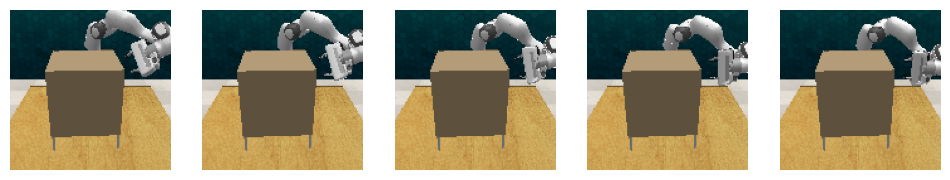


Generated images by the model:


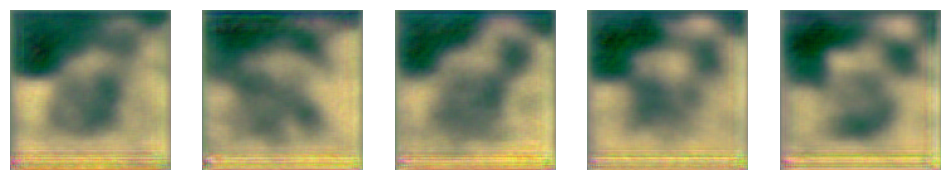


target last action of sequence
[ 0.1621  0.2356  1.1546 -0.7068 -0.0189 -0.019  -0.7069  1.    ]

predicted last action of sequence
[ 0.7214  0.2962  1.3805 -0.4177 -0.8322  0.1968 -0.6318  1.    ]


---- batch 1 epoch 10 iteration: 32 
continuous loss 8.175631523132324 gripper_loss 0.6937509179115295 image_loss 30443.0078125 reward_loss 0.2670263946056366 z_loss 123433.515625-----



Input images :


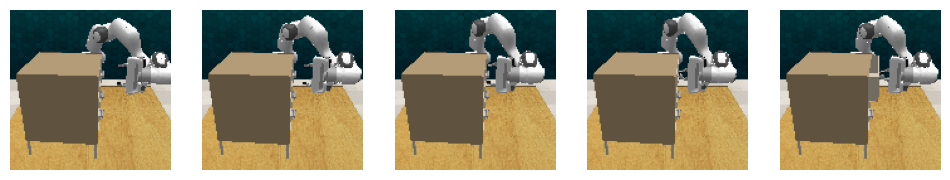


Generated images by the model:


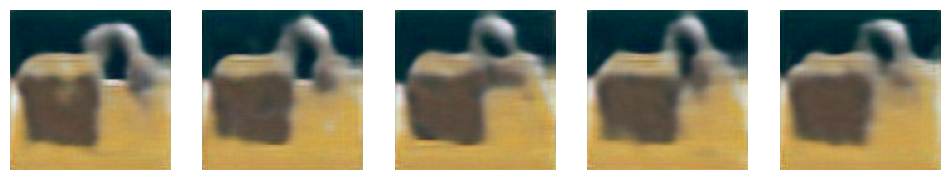


target last action of sequence
[ 0.2593  0.1593  1.1556 -0.7063  0.0298  0.03   -0.7067  0.    ]

predicted last action of sequence
[ 0.1972  0.241   1.0581 -0.7993  0.0803 -0.0387 -0.6313  1.    ]


---- batch 1 epoch 20 iteration: 32 
continuous loss 9.451776504516602 gripper_loss 0.39199718832969666 image_loss 21576.9609375 reward_loss 0.13764862716197968 z_loss 112604.3359375-----



Input images :


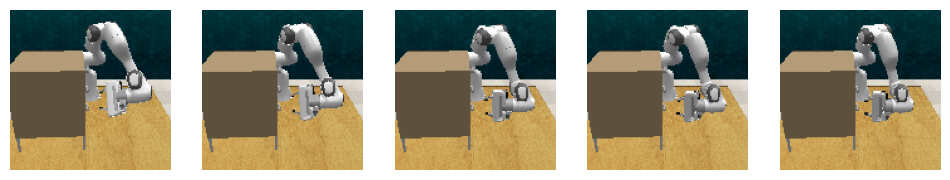


Generated images by the model:


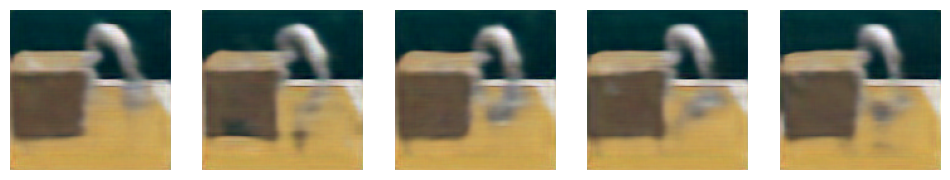


target last action of sequence
[ 0.1778 -0.0264  0.915  -0.7068 -0.0183 -0.0181 -0.7069  1.    ]

predicted last action of sequence
[ 0.2636  0.0912  1.0861 -0.754   0.1922 -0.0517 -0.6344  1.    ]


---- batch 1 epoch 30 iteration: 32 
continuous loss 11.640745162963867 gripper_loss 0.40521812438964844 image_loss 17455.265625 reward_loss 0.10055350512266159 z_loss 106163.265625-----



Input images :


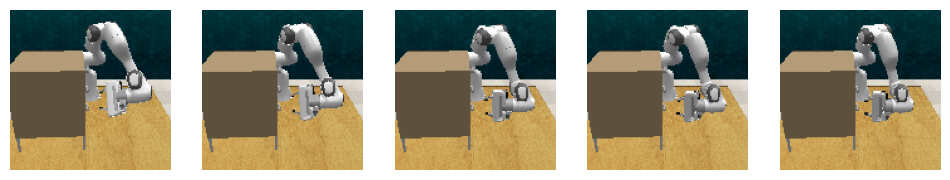


Generated images by the model:


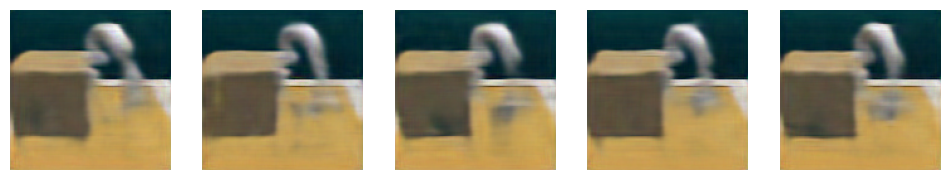


target last action of sequence
[ 0.1778 -0.0264  0.915  -0.7068 -0.0183 -0.0181 -0.7069  1.    ]

predicted last action of sequence
[ 0.1699  0.161   1.1428 -0.8634  0.2651 -0.086  -0.6626  1.    ]


---- batch 1 epoch 40 iteration: 32 
continuous loss 6.604081153869629 gripper_loss 1.1632834672927856 image_loss 13482.4404296875 reward_loss 0.5087094306945801 z_loss 97458.9765625-----



Input images :


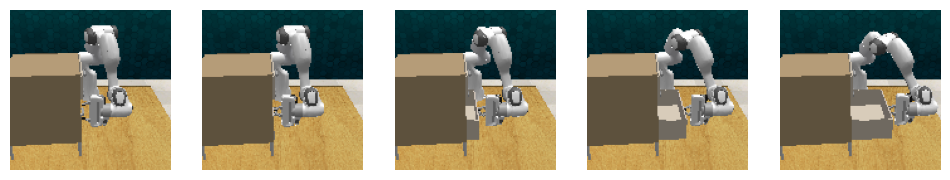


Generated images by the model:


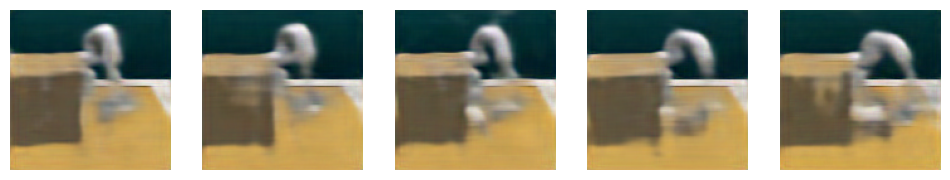


target last action of sequence
[ 0.2133  0.18    0.9153 -0.7063 -0.028  -0.0283 -0.7067  0.    ]

predicted last action of sequence
[ 0.2598 -0.0292  1.0076 -0.7777  0.0483  0.0142 -0.6402  1.    ]


---- batch 1 epoch 50 iteration: 32 
continuous loss 14.753446578979492 gripper_loss 0.38316598534584045 image_loss 8378.6181640625 reward_loss 0.07894866913557053 z_loss 95769.0-----



Input images :


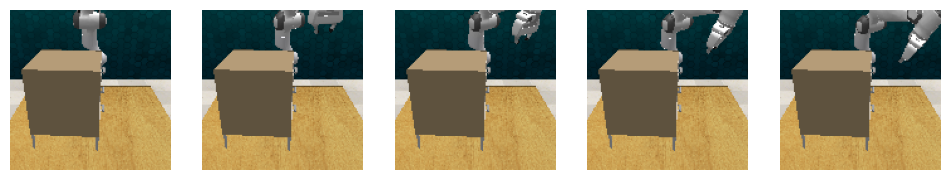


Generated images by the model:


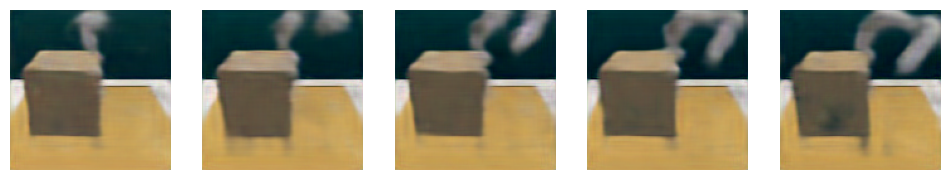


target last action of sequence
[ 0.2159  0.2081  1.1907 -0.6372  0.6879 -0.1292 -0.3225  1.    ]

predicted last action of sequence
[ 0.3727  0.0564  1.1226 -0.4026  0.4121 -0.1389 -0.2467  1.    ]


---- batch 1 epoch 60 iteration: 32 
continuous loss 9.710901260375977 gripper_loss 0.3667662739753723 image_loss 8434.646484375 reward_loss 0.06873580813407898 z_loss 96553.671875-----



Input images :


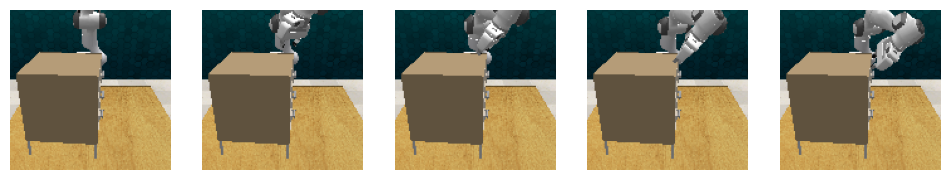


Generated images by the model:


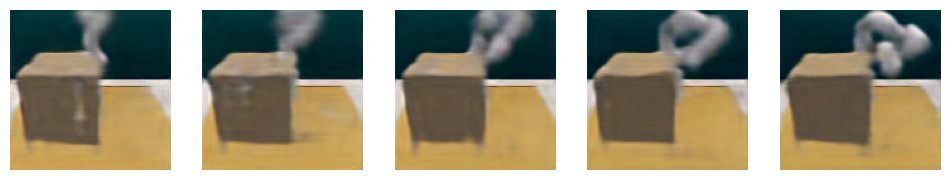


target last action of sequence
[ 0.2788  0.0706  1.2133 -0.7118  0.5109 -0.1183 -0.4671  1.    ]

predicted last action of sequence
[ 0.4012  0.1046  1.1258 -0.4594  0.4808 -0.062  -0.2475  1.    ]


---- batch 1 epoch 70 iteration: 32 
continuous loss 6.9144721031188965 gripper_loss 0.43989211320877075 image_loss 8326.0966796875 reward_loss 0.06427057832479477 z_loss 90334.125-----



Input images :


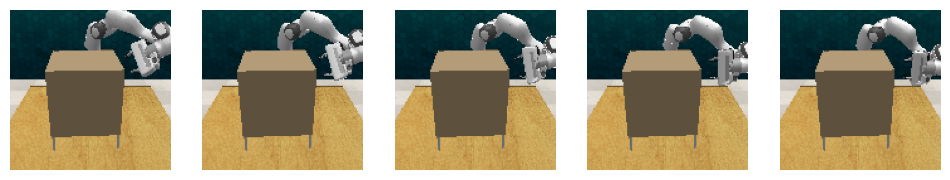


Generated images by the model:


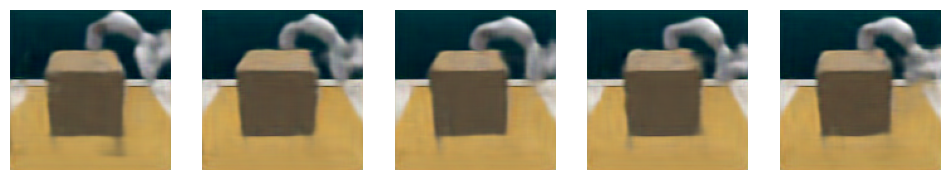


target last action of sequence
[ 0.1621  0.2356  1.1546 -0.7068 -0.0189 -0.019  -0.7069  1.    ]

predicted last action of sequence
[ 0.2405  0.0643  0.9132 -0.7751  0.0037  0.0128 -0.89    1.    ]


---- batch 1 epoch 80 iteration: 32 
continuous loss 5.9944305419921875 gripper_loss 0.3739398717880249 image_loss 6926.5966796875 reward_loss 0.0608954094350338 z_loss 93465.921875-----



Input images :


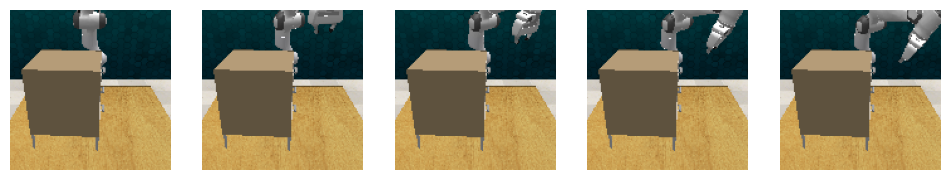


Generated images by the model:


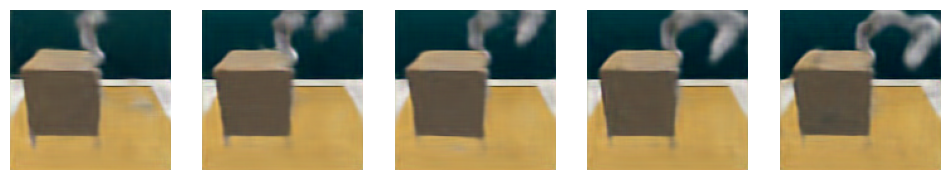


target last action of sequence
[ 0.2159  0.2081  1.1907 -0.6372  0.6879 -0.1292 -0.3225  1.    ]

predicted last action of sequence
[ 0.2064  0.0972  1.2495 -0.5539  0.7698 -0.1462 -0.2486  1.    ]


---- batch 1 epoch 90 iteration: 32 
continuous loss 9.058349609375 gripper_loss 0.3507833182811737 image_loss 7483.38916015625 reward_loss 0.058655381202697754 z_loss 93745.859375-----



Input images :


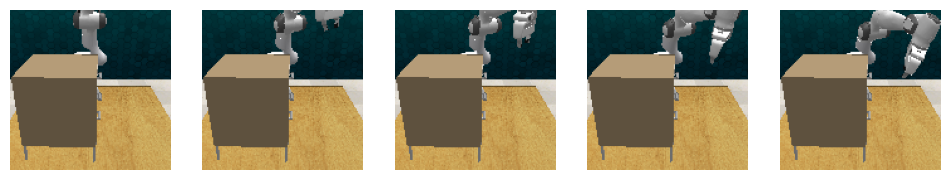


Generated images by the model:


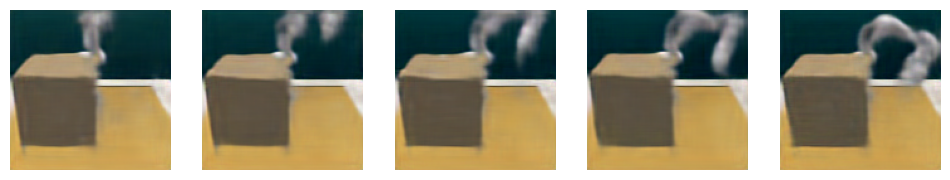


target last action of sequence
[ 0.3167  0.2063  1.1273 -0.7027  0.6538 -0.0967 -0.2633  1.    ]

predicted last action of sequence
[ 0.2188  0.0874  1.3086 -0.4471  0.8224 -0.1359 -0.2062  1.    ]


---- batch 1 epoch 100 iteration: 32 
continuous loss 2.114816904067993 gripper_loss 0.5663203001022339 image_loss 7456.4912109375 reward_loss 0.0568520687520504 z_loss 88476.5-----



Input images :


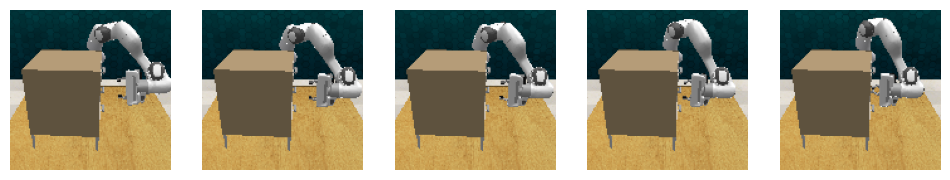


Generated images by the model:


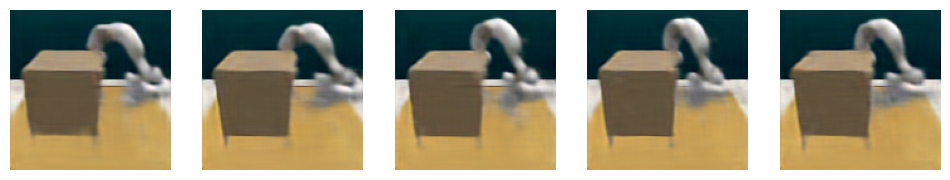


target last action of sequence
[ 0.1892  0.0919  1.0357 -0.7065  0.0226  0.0224 -0.707   0.    ]

predicted last action of sequence
[ 0.295   0.114   0.9138 -0.6824 -0.1145  0.026  -0.8063  1.    ]


In [48]:


loss_weights = (10,1,1,1,10)
for epoch in range(epochs):
    train(my_train_dataloader, model, optimizer=optz, loss_weights=loss_weights, epoch=epoch, logging_step=10)

In [49]:
torch.save(my_perceiver_encoder.state_dict(), "my_peract_future_image_gen.pth")

In [63]:
# torch.autograd.set_detect_anomaly(True)
def test(dataloader, model):
    device = 'cpu'
    my_perceiver_encoder = model.to('cpu')
    
    agnt = MyPeractAgent(my_perceiver_encoder, optimizer=None)
    for index, d in enumerate(my_train_dataloader):
      # print(d)
      obs, targets = d
    
      actions, imgs, langs, rewards, _, preprio = obs
      targets_actions, targets_imgs, targets_rewards = targets

      # actions_list, rgb_list,lang_goals_list,rewards_list, ignore_list,low_dim_list, targets_list
      actions = process_replay_output(actions).to(device)
    

      imgs = _norm_rgb(process_replay_output(imgs)).to(device)
#       plot_images(_denorm_rgb(imgs[0]))
      langs = process_replay_output(langs).to(device)
      rewards = process_replay_output(rewards).unsqueeze(-1).to(device)
      preprio = process_replay_output(preprio).to(device)

      targets_actions = process_replay_output(targets_actions).to(device)
      targets_imgs = _norm_rgb(process_replay_output(targets_imgs)).to(device)

      obs = actions, imgs, langs, rewards, _, preprio
      targets_rewards = process_replay_output(targets_rewards).to(device)
#       print("rewards and target rewards", rewards.reshape(targets_rewards.shape), targets_rewards)
      # print(targets_actions[:,:,:-1].shape, targets_actions[:,:,-1].shape)
      targets = (targets_actions, imgs, targets_rewards)
      preds = agnt.step(obs, training=False)

        
    
      print(f"\n\n-------------------------- batch size {targets_actions.shape[0]} iteration: {index} loss --------------------------\n\n")
      #         print(f"batch {targets_actions.shape[0]} epoch {epoch} iteration: {index} loss {loss}")
      action_preds, gripper_open_preds, reward_preds, img_hat, z_loss, imagined_image = preds
      img_hat, _, _ = img_hat
      print("\nInput images :")
      plot_images(_denorm_rgb(imgs[0]))
      print("\nTarget images :")
      plot_images(_denorm_rgb(targets_imgs[0]))
      print("\nGenerated images by the model:")
      plot_images(_denorm_rgb(img_hat[0]))
      print("\Imagined images by the model:")
      plot_images(_denorm_rgb(imagined_image[0]))
      print("\ntarget last action of sequence")
      print(np.round(targets_actions.detach().cpu().numpy()[0][-1], decimals=4))  
      print("\npredicted last action of sequence")
      gripp = (nn.functional.sigmoid(gripper_open_preds) >= 0.5).float()
      actz = np.concatenate((action_preds.detach().cpu().numpy()[0][-1], gripp.detach().cpu().numpy()[0][-1]))
      print(np.round(actz, decimals=4))
      break



-------------------------- batch size 1 iteration: 0 loss --------------------------



Input images :


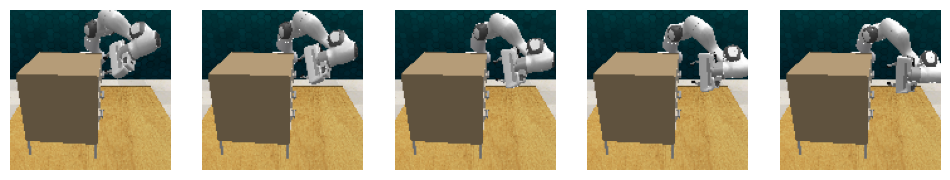


Target images :


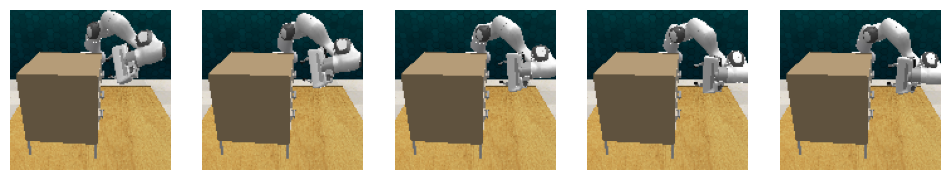


Generated images by the model:


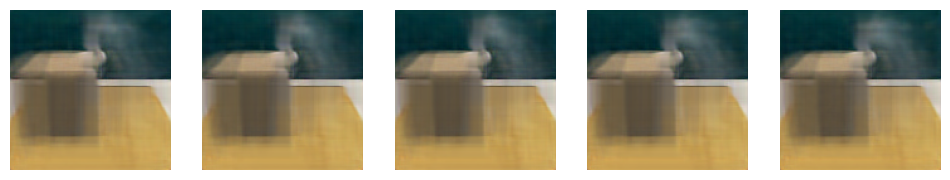

\Imagined images by the model:


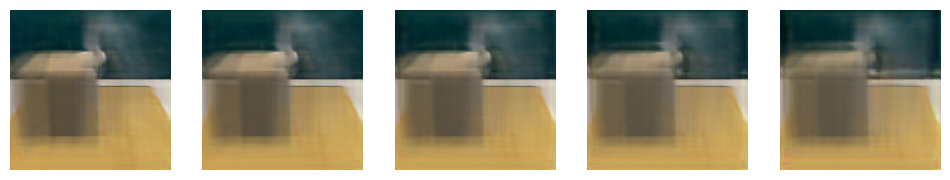


target last action of sequence
[ 0.2578  0.144   1.1542 -0.7063  0.0298  0.0304 -0.7066  1.    ]

predicted last action of sequence
[ 0.2734  0.1208  1.1721 -0.7774  0.0086  0.0224 -0.7574  1.    ]


In [64]:
test(my_train_dataloader, my_perceiver_encoder)

## Citations

**PerAct**
```
@inproceedings{shridhar2022peract,
  title     = {Perceiver-Actor: A Multi-Task Transformer for Robotic Manipulation},
  author    = {Shridhar, Mohit and Manuelli, Lucas and Fox, Dieter},
  booktitle = {Proceedings of the 6th Conference on Robot Learning (CoRL)},
  year      = {2022},
}
```

**C2FARM**
```
@inproceedings{james2022coarse,
  title={Coarse-to-fine q-attention: Efficient learning for visual robotic manipulation via discretisation},
  author={James, Stephen and Wada, Kentaro and Laidlow, Tristan and Davison, Andrew J},
  booktitle={Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition},
  pages={13739--13748},
  year={2022}
}
```

**PerceiverIO**
```
@article{jaegle2021perceiver,
  title={Perceiver io: A general architecture for structured inputs \& outputs},
  author={Jaegle, Andrew and Borgeaud, Sebastian and Alayrac, Jean-Baptiste and Doersch, Carl and Ionescu, Catalin and Ding, David and Koppula, Skanda and Zoran, Daniel and Brock, Andrew and Shelhamer, Evan and others},
  journal={arXiv preprint arXiv:2107.14795},
  year={2021}
}
```


**RLBench**
```
@article{james2020rlbench,
  title={Rlbench: The robot learning benchmark \& learning environment},
  author={James, Stephen and Ma, Zicong and Arrojo, David Rovick and Davison, Andrew J},
  journal={IEEE Robotics and Automation Letters},
  volume={5},
  number={2},
  pages={3019--3026},
  year={2020},
  publisher={IEEE}
}
```